## ERDAP with erddapy example for FCOM ITAE Prawler - 2021 M2 (BSPR-2A)

__pyversion__==3.7   
__author__==S.Bell

__Notes:__ 
+ Raw Science Units are what is being hosted on ERDDAP client.    
+ Salinity must be calculated from Conductivity   
+ OxyConc must be corrected for Salinity/Press   
+ Turb/Chlor must be calculated from counts   
+ TELOS ('http://heron:8080/erddap') erddap doesn't keep a divenumber value (and its not trivial to sort this data) so second erddap is hosting this data in order to keep that parameter ('http://downdraft.pmel.noaa.gov:8080/erddap') some preprocessing is happening there prior to data posting.  Incomming -> Science -> QC'd data is a source of future conversation for erddap hosting.

__Todo:__
+ Initial QC can be done   
+ csv files of converted data should be archived at end of deployment?

***
There is an issue with the SBE temp probe... 
***

In [1]:
import datetime
print("Last run {0}".format(datetime.datetime.now()))

Last run 2021-06-15 09:23:37.119756


### connecting and basic information

In [2]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

import seawater as sw
import calc.aanderaa_corrO2_sal as optode_O2_corr

server_url = 'http://akutan.pmel.noaa.gov:8080/erddap'
server_url = 'http://heron:8080/erddap'
#alternate server_url = 'http://redwing:8080/erddap'

e = ERDDAP(server=server_url)

In [3]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='M200'))

In [4]:
'We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
)

'We have 8 tabledap, 0 griddap, and 0 wms endpoints.'

In [5]:
prawlers = df['Dataset ID'].values
print(prawlers)

['TELOM200_ATRH' 'TELOM200_BARO' 'TELOM200_GPS_M200' 'TELOM200_PRAWE_M200'
 'TELOM200_PRAWE_M200-SCI' 'TELOM200_PRAWC_M200' 'TELOM200_WIND'
 'TELOM200_PRAWC_M200-SCI']


In [6]:
variables = [e.get_var_by_attr(dataset_id=prawler, standard_name=lambda v: v is not None) for prawler in prawlers]
print(variables)

[['RH', 'time'], ['time'], ['Latitude', 'time', 'Longitude'], ['SRate', 'IRate', 'Depth', 'time', 'ETimer'], ['longitude', 'latitude', 'SRate', 'IRate', 'Depth', 'time', 'ETimer'], ['wetlab_Chlorophyll', 'time', 'SB_Temp', 'Epoch_Time', 'SB_Depth', 'Optode_Dissolved_O2', 'SB_Conductivity', 'wetlab_FDOM', 'Optode_Temp'], ['time'], ['wetlab_Chlorophyll', 'time', 'SB_Temp', 'latitude', 'Epoch_Time', 'SB_Depth', 'Optode_Dissolved_O2', 'SB_Conductivity', 'longitude', 'wetlab_FDOM', 'Optode_Temp']]


### retrieving and plotting data

In [7]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='TELOM200_PRAWC_M200'

d.variables =  [
 'SB_Depth',
 'SB_Temp',
 'SB_Conductivity',
 'Optode_Temp',
 'Optode_Dissolved_O2',
 'wetlab_Chlorophyll',
 'wetlab_FDOM',
 "time"
]


d.constraints = {
    'time>=': '2021-02-01T00:00:00Z',
    'time<=': '2021-08-01T00:00:00Z',
}

In [8]:
d.get_download_url()

'http://heron:8080/erddap/tabledap/TELOM200_PRAWC_M200.csv?SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM,time&time>=1612137600.0&time<=1627776000.0'

In [9]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df = df.sort_index()

df.head()

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM
time (UTC),,,,,,,
2021-05-05 05:36:22+00:00,4.27,2.531,2.905,2.691,391.25,134.0,146.0
2021-05-05 05:36:30+00:00,3.88,2.585,2.907,2.688,391.21,119.0,128.0
2021-05-05 05:36:38+00:00,3.91,2.656,2.907,2.682,391.30,123.0,135.0
2021-05-05 05:36:46+00:00,4.64,2.656,2.907,2.682,391.26,132.0,141.0
2021-05-05 05:36:54+00:00,5.15,2.656,2.907,2.687,391.11,138.0,133.0


In [10]:
df.tail()

,SB_Depth,SB_Temp,SB_Conductivity,Optode_Temp,Optode_Dissolved_O2,wetlab_Chlorophyll,wetlab_FDOM
time (UTC),,,,,,,
2021-06-15 12:15:15+00:00,40.86,2.789,2.928,2.940,342.22,125.0,106.0
2021-06-15 12:15:23+00:00,42.45,2.784,2.927,2.923,340.94,134.0,96.0
2021-06-15 12:15:31+00:00,44.02,2.781,2.926,2.920,339.83,118.0,105.0
2021-06-15 12:15:39+00:00,45.36,2.779,2.926,2.916,339.13,113.0,96.0
2021-06-15 12:15:47+00:00,46.72,2.774,2.926,2.912,338.55,117.0,123.0


In [11]:
# #temp load from local
# ctd_pd = '/Users/bell/Downloads/TELOM200_PRAWC_M200_8c09_6bd2_5833.csv'
# df = pd.read_csv(ctd_pd,index_col='time',skiprows=[1],parse_dates=True)
# df.index.name = 'time (UTC)'

#### Temperature

In [12]:
#qc
df['SB_Temp'][df['SB_Temp']>20]=np.nan

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

Text(0, 0.5, 'Depth (m)')

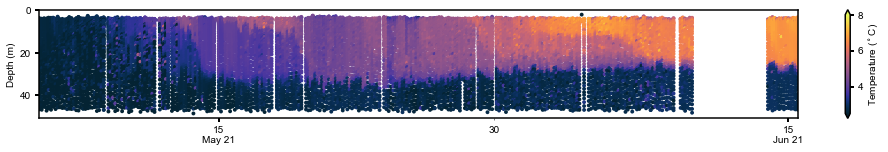

In [15]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['SB_Temp'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.thermal,vmin=2.5,vmax=8.0) #<---
ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


Text(0, 0.5, 'Depth (m)')

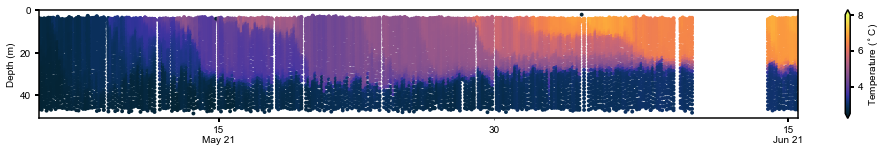

In [16]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['Optode_Temp'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.thermal,vmin=2.5,vmax=8.0)
ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')


In [17]:
print("""
max temp: {0:0.4}
min temp: {1:0.4}""".format(df['SB_Temp'].max(), df['SB_Temp'].min()))


max temp: 7.492
min temp: -1.108


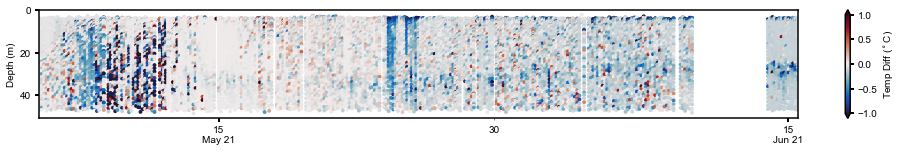

In [18]:
#plot
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['SB_Temp']-df['Optode_Temp'], 
                marker='o', edgecolor='none', vmin=-1,vmax=1,cmap=cmocean.cm.balance)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temp Diff ($^\circ$C)')
ax.set_ylabel('Depth (m)');

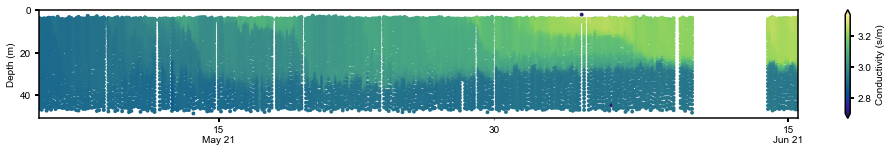

In [19]:
#bounds
lower = df['SB_Conductivity'].mean()-3*df['SB_Conductivity'].std()
upper = df['SB_Conductivity'].mean()+3*df['SB_Conductivity'].std()

#plot
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['SB_Conductivity'], 
                marker='o', edgecolor='none', vmin=lower, vmax=upper, cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Conductivity (s/m)')
ax.set_ylabel('Depth (m)');

#### Salinity

In [20]:
### calculate salinity from conductivity
df['Salinity (PSU)'] = sw.salt(r=df['SB_Conductivity']/4.2914,t=df['SB_Temp'],p=df['SB_Depth'])
df['Salinity (PSU) aandT'] = sw.salt(r=df['SB_Conductivity']/4.2914,t=df['Optode_Temp'],p=df['SB_Depth'])

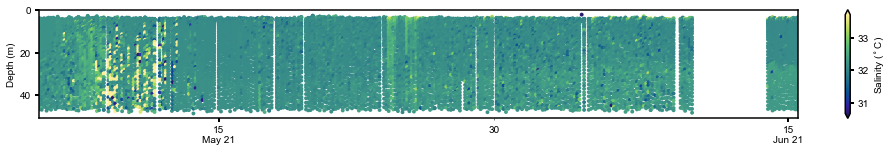

In [21]:
#bounds
lower = df['Salinity (PSU)'].mean()-3*df['Salinity (PSU)'].std()
upper = df['Salinity (PSU)'].mean()+3*df['Salinity (PSU)'].std()

#plot
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['Salinity (PSU)'], 
                marker='o', edgecolor='none', vmin=lower, vmax=upper, cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

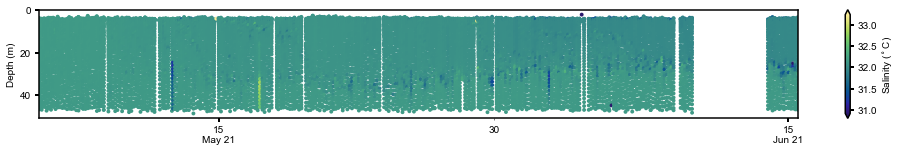

In [22]:
#bounds
lower = df['Salinity (PSU) aandT'].mean()-3*df['Salinity (PSU) aandT'].std()
upper = df['Salinity (PSU) aandT'].mean()+3*df['Salinity (PSU) aandT'].std()

#plot
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['Salinity (PSU) aandT'], 
                marker='o', edgecolor='none', vmin=lower, vmax=upper, cmap=cmocean.cm.haline)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity ($^\circ$C)')
ax.set_ylabel('Depth (m)');

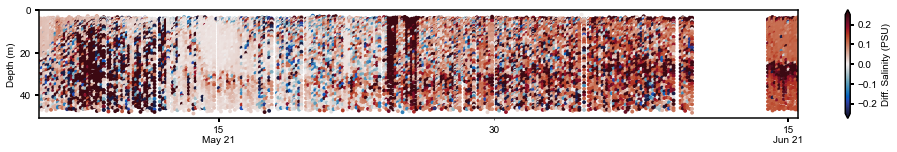

In [23]:
#plot
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['Salinity (PSU)']-df['Salinity (PSU) aandT'], 
                marker='o', edgecolor='none', vmin=-.25,vmax=.25,cmap=cmocean.cm.balance)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Diff. Salinity (PSU)')
ax.set_ylabel('Depth (m)');

In [24]:
print("""
max sal: {0:0.4}
min sal: {1:0.4}""".format(df['Salinity (PSU)'].max(), df['Salinity (PSU)'].min()))

print("""
mean sal: {0:0.4}
sal std: {1:04}""".format(df['Salinity (PSU)'].mean(),df['Salinity (PSU)'].std()))


max sal: 36.64
min sal: 0.05836

mean sal: 32.19
sal std: 0.5036678394692992


#### Chlorophyl

Text(0, 0.5, 'Depth (m)')

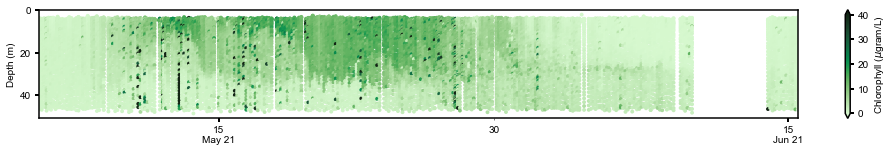

In [25]:
df['wetlab_Chlorophyll_ug/l'] = (df['wetlab_Chlorophyll']-56)*0.0129

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['wetlab_Chlorophyll_ug/l'], 
                marker='o', vmin =0, vmax= 40, edgecolor='none', cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/L)')
ax.set_ylabel('Depth (m)')


In [26]:
print("""
max chlorophyll: {0:0.4}
min chlorophyll: {1:0.4}""".format(df['wetlab_Chlorophyll_ug/l'].max(), df['wetlab_Chlorophyll_ug/l'].min()))


max chlorophyll: 52.4
min chlorophyll: 0.0258


#### Chlorophyl (log scale)

Text(0, 0.5, 'Depth (m)')

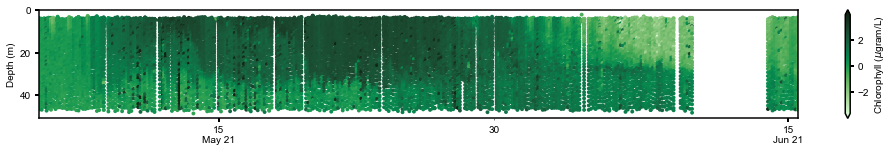

In [27]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=np.log(df['wetlab_Chlorophyll_ug/l']), 
                marker='o', edgecolor='none', cmap=cmocean.cm.algae)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Chlorophyll ($\mu$gram/L)')
ax.set_ylabel('Depth (m)')

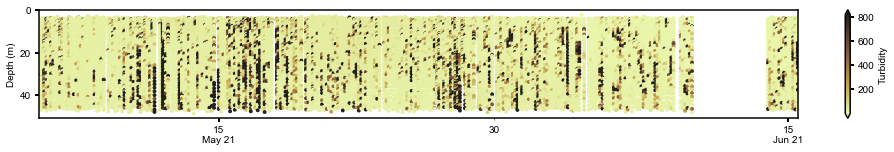

In [28]:
df['wetlab_FDOM_NTU'] = (df['wetlab_FDOM']-51)*0.2022

fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['wetlab_FDOM_NTU'], 
                marker='o', edgecolor='none', cmap=cmocean.cm.turbid)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Turbidity')
ax.set_ylabel('Depth (m)');

In [29]:
import seawater as sw
sigmat = sw.dens(s=df['Salinity (PSU) aandT'],t=df['SB_Temp'],p=df['SB_Depth']) - 1000.

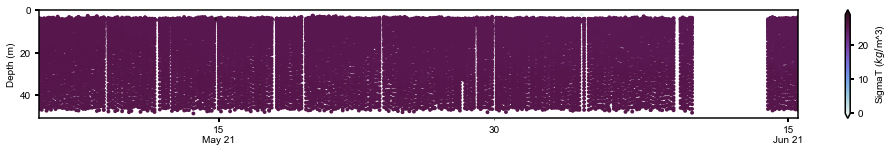

In [30]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=sigmat, 
                marker='o', edgecolor='none', cmap=cmocean.cm.dense)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('SigmaT ($kg/$m^3)')
ax.set_ylabel('Depth (m)');

In [31]:
### Oxygen with Salinity Correction

### sal correct and convert oxygen
df['O2_corr'] = optode_O2_corr.O2_sal_comp(oxygen_conc=df['Optode_Dissolved_O2'],
                                     salinity=df['Salinity (PSU) aandT'],
                                     temperature=df['Optode_Temp'])
df['O2_corr_umkg'] = optode_O2_corr.O2_molar2umkg(oxygen_conc=df.O2_corr,
                                     salinity=df['Salinity (PSU) aandT'],
                                     temperature=df['Optode_Temp'],
                                     pressure=df['SB_Depth'])

df['O2PercentSat'] = optode_O2_corr.O2PercentSat(oxygen_conc=df.O2_corr_umkg,
                                     salinity=df['Salinity (PSU) aandT'],
                                     temperature=df['Optode_Temp'],
                                     pressure=df['SB_Depth'])

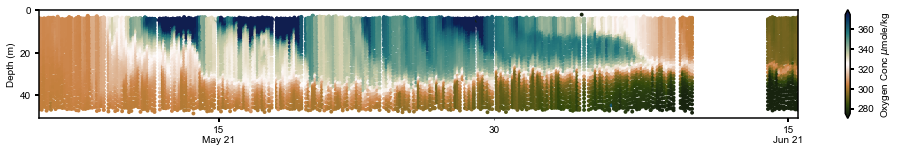

In [32]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['O2_corr_umkg'], 
                marker='o', vmin=275, vmax=375, edgecolor='none', cmap=cmocean.cm.tarn)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Conc $\mu$mole/kg')
ax.set_ylabel('Depth (m)');

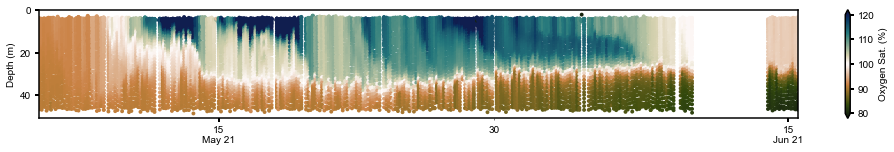

In [33]:
fig, ax = plt.subplots(figsize=(17, 2))
cs = ax.scatter(df.index, df['SB_Depth'], s=15, c=df['O2PercentSat'], 
                marker='o', vmin=80, vmax=120, edgecolor='none', cmap=cmocean.cm.tarn)

ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(range(0,32,15)))
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%d\n%b %y'))
ax.xaxis.set_tick_params(which='major', pad=3)
ax.xaxis.set_tick_params(which='minor', pad=5)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Oxygen Sat. (%)')
ax.set_ylabel('Depth (m)');

In [34]:
print(f"""
max oxygen percent: {df['O2PercentSat'].max():0.4}
min oxygen percent: {df['O2PercentSat'].min():0.4}""")


max oxygen percent: 140.7
min oxygen percent: 0.4387


In [35]:
df.to_csv('~/Desktop/21bspr2a.csv')

In [36]:
#grid and replot
from netCDF4 import date2num, num2date
from scipy import interpolate

time_grid = pd.date_range(df.index[0].round('H'),df.index[-1],freq='1h')
press_grid = np.arange(0,50.25,1)

In [37]:
profile_counter = 0
df['profileNum'] = np.nan
for i,row in (df.diff()).iterrows():
    try:
        if (row['SB_Depth']<-20):
            profile_counter+=1
            df['profileNum'][i]=profile_counter
        else:
            df['profileNum'][i]=profile_counter
    except:
        df['profileNum'][i]=profile_counter

In [38]:
def profile(cast,press_grid=np.arange(0,50.25,1),fillgaps=True):
    """ For a single profile, take median values
    Linearly interpolate to fillgaps"""
    #skip profile if std of depth is less than 1 - likely a park and hold
    if np.std(cast['SB_Depth']) <= 1.0:
        #calibration profile
        return
    else:
        # full profile
        #initialize profile parameters
        profiledata = {'Salinity (PSU) aandT': [],
                      'Optode_Temp': [],
                      'wetlab_Chlorophyll_ug/l': [],
                      'O2PercentSat': [],
                      'O2_corr_umkg': []}

        #fill variables for each profile, taking the median if multiple values within same depth bin
        # and making NaN if no values
        for pg in press_grid:
            """ Take the median value if multiple samples occur within same depth bin"""
            for parameter in profiledata.keys():
                if not parameter in ['Statistics']:
                    ireg_ind = np.where((cast['SB_Depth'] > pg) & (cast['SB_Depth'] <= pg+1))
                    profiledata[parameter] = np.hstack((profiledata[parameter], cast[parameter][ireg_ind[0]].median()))
                else:
                    profiledata['Statistics'] = np.hstack((profiledata['Statistics'], ireg_ind[0].size))

        for parameter in profiledata.keys():
            if fillgaps:
                mask = np.isnan(profiledata[parameter])
                profiledata[parameter][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), profiledata[parameter][~mask], right=np.nan)

        profiledata['datetime'] = cast.index[0].to_pydatetime()
        return(profiledata)

def time_interp(date_min,date_max,dt=1.0/24.0):
    dt_min = date2num(date_min -datetime.timedelta(seconds=60*date_min.minute + date_min.second),'Days since 0001-1-1')
    time_grid = np.arange(dt_min,date2num(date_max,'Days since 0001-1-1'),dt) #grid limits -> set to top of hour
    
    return(time_grid)

In [39]:
profiledata_filled = {}

dfsg= df.groupby('profileNum')

for profileid in list(dfsg.groups.keys()):
    tmp = profile(dfsg.get_group(profileid))
    if tmp:
        profiledata_filled.update({profileid: tmp})

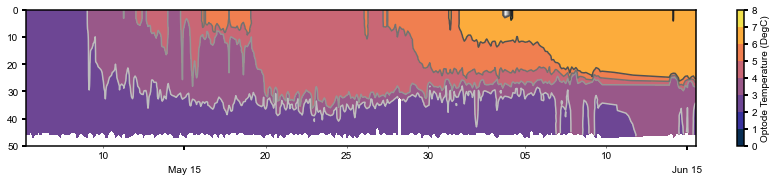

In [40]:
parameter='Optode_Temp'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]

time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

mesh_grid_func = interpolate.interp2d(date_time,press_grid,np.array(np2d).T,kind='linear',bounds_error=False,fill_value=np.nan)
mesh_grid_OxyConc_ph = mesh_grid_func(press_grid,time_grid)

fig = plt.figure(figsize=(15,2.5))
ax = plt.subplot(1,1,1)
cs = plt.contourf(date_time,press_grid,np.array(np2d).T, cmap=cmocean.cm.thermal)
cbar = fig.colorbar(cs, orientation='vertical')
cs = plt.contour(date_time,press_grid,np.array(np2d).T, )
cbar.ax.set_ylabel('Optode Temperature (DegC)')
ax.invert_yaxis()
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
ax.xaxis.set_tick_params(which='major', pad=15)


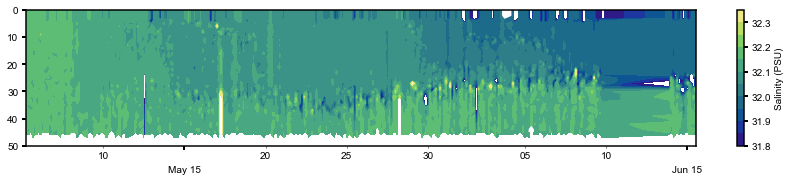

In [41]:
parameter='Salinity (PSU) aandT'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]

time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

mesh_grid_func = interpolate.interp2d(date_time,press_grid,np.array(np2d).T,kind='linear',bounds_error=False,fill_value=np.nan)
mesh_grid_OxyConc_ph = mesh_grid_func(press_grid,time_grid)

fig = plt.figure(figsize=(15,2.5))
ax = plt.subplot(1,1,1)
cs = plt.contourf(date_time,press_grid,np.array(np2d).T, cmap=cmocean.cm.haline, levels=np.arange(31.8,32.4,.05))
cbar = fig.colorbar(cs, orientation='vertical')
cs = plt.contour(date_time,press_grid,np.array(np2d).T,vmin=31.2,vmax=32.5 )
cbar.ax.set_ylabel('Salinity (PSU)')
ax.invert_yaxis()
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
ax.xaxis.set_tick_params(which='major', pad=15)


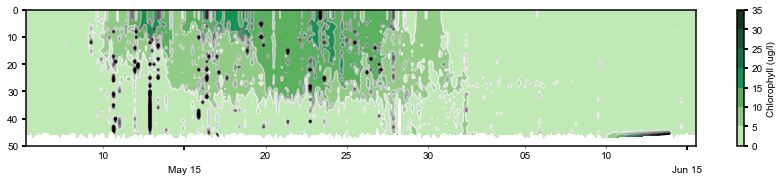

In [42]:
parameter='wetlab_Chlorophyll_ug/l'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]

time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

mesh_grid_func = interpolate.interp2d(date_time,press_grid,np.array(np2d).T,kind='linear',bounds_error=False,fill_value=np.nan)
mesh_grid_OxyConc_ph = mesh_grid_func(press_grid,time_grid)

fig = plt.figure(figsize=(15,2.5))
ax = plt.subplot(1,1,1)
cs = plt.contourf(date_time,press_grid,np.array(np2d).T, cmap=cmocean.cm.algae, levels=range(0,40,5))
cbar = fig.colorbar(cs, orientation='vertical')
cs = plt.contour(date_time,press_grid,np.array(np2d).T, levels=range(0,40,5) )
cbar.ax.set_ylabel('Chlorophyll (ug/l)')
ax.invert_yaxis()
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
ax.xaxis.set_tick_params(which='major', pad=15)


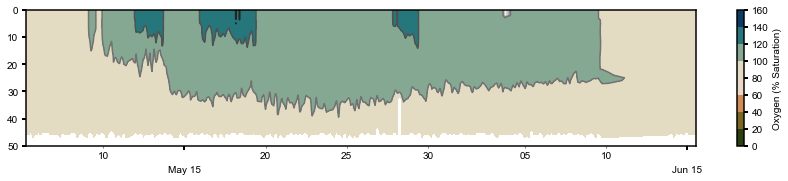

In [43]:
parameter='O2PercentSat'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]

time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

mesh_grid_func = interpolate.interp2d(date_time,press_grid,np.array(np2d).T,kind='linear',bounds_error=False,fill_value=np.nan)
mesh_grid_OxyConc_ph = mesh_grid_func(press_grid,time_grid)

fig = plt.figure(figsize=(15,2.5))
ax = plt.subplot(1,1,1)
cs = plt.contourf(date_time,press_grid,np.array(np2d).T, cmap=cmocean.cm.tarn)
cbar = fig.colorbar(cs, orientation='vertical')
cs = plt.contour(date_time,press_grid,np.array(np2d).T, )
cbar.ax.set_ylabel('Oxygen (% Saturation)')
ax.invert_yaxis()
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
ax.xaxis.set_tick_params(which='major', pad=15)


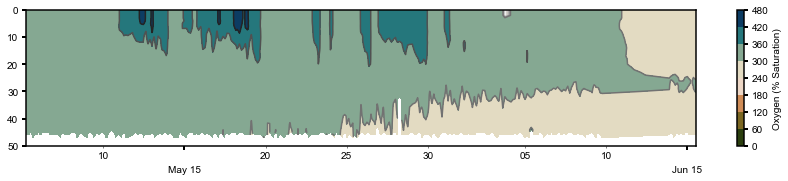

In [44]:
parameter='O2_corr_umkg'
np2d=[]
np2d = [np2d + list(v[parameter]) for k,v in profiledata_filled.items()]

time_grid = time_interp(profiledata_filled[list(profiledata_filled.keys())[0]]['datetime'],
                        profiledata_filled[list(profiledata_filled.keys())[-1]]['datetime'])

date_time = [date2num(v['datetime'],'Days since 0001-1-1') for k,v in profiledata_filled.items()]

mesh_grid_func = interpolate.interp2d(date_time,press_grid,np.array(np2d).T,kind='linear',bounds_error=False,fill_value=np.nan)
mesh_grid_OxyConc_ph = mesh_grid_func(press_grid,time_grid)

fig = plt.figure(figsize=(15,2.5))
ax = plt.subplot(1,1,1)
cs = plt.contourf(date_time,press_grid,np.array(np2d).T, cmap=cmocean.cm.tarn)
cbar = fig.colorbar(cs, orientation='vertical')
cs = plt.contour(date_time,press_grid,np.array(np2d).T, )
cbar.ax.set_ylabel('Oxygen (% Saturation)')
ax.invert_yaxis()
ax.xaxis.set_major_locator(DayLocator(bymonthday=15))
ax.xaxis.set_minor_locator(DayLocator(bymonthday=[5,10,15,20,25,30]))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_minor_formatter(DateFormatter('%d'))
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
ax.xaxis.set_tick_params(which='major', pad=15)
